In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from argparse import Namespace
from pathlib import Path
import numpy as np

import torch
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule
from turboflow.evaluation import compute_all_metrics
from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch

import matplotlib.pyplot as plt

In [4]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

In [22]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=int(1024),
                         time_idx=np.arange(32),
                         train_downsampling_space=4,
                         val_downsampling_space=4,
                         test_downsampling_space=4,
                         
                         train_downsampling_time=2,
                         val_downsampling_time=2,
                         test_downsampling_time=2,
                         
                         train_shuffle=True,
                         val_shuffle=False,
                         test_shuffle=False,
                         num_workers=1)
dm.setup()

In [23]:
print(dm.train_shuffle)
X, y = dm.train_dataset[:]

print(X[-10:,:])
print(X.shape)

True
tensor([[0.3000, 0.9882, 0.8471],
        [0.3000, 0.9882, 0.8627],
        [0.3000, 0.9882, 0.8784],
        [0.3000, 0.9882, 0.8941],
        [0.3000, 0.9882, 0.9098],
        [0.3000, 0.9882, 0.9255],
        [0.3000, 0.9882, 0.9412],
        [0.3000, 0.9882, 0.9569],
        [0.3000, 0.9882, 0.9725],
        [0.3000, 0.9882, 0.9882]])
torch.Size([65536, 3])


Low Resolution data:
-- D dimensions: 3
-- T times: 16
-- N samples: 65536
-- R resolution img: 64
-- img-like input shape: (16, 64, 64, 3)
-- vct-like input shape: (65536, 3)
-- img-like output shape: (16, 64, 64, 2)
-- vct-like output shape: (65536, 2)
tensor(0.9307) tensor(-0.9889)
torch.Size([64, 64])


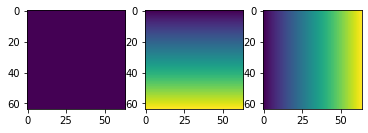

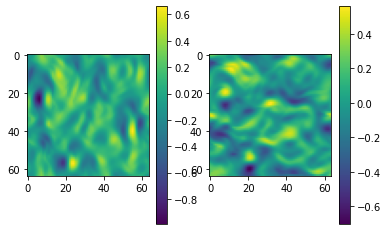

torch.Size([64, 64])


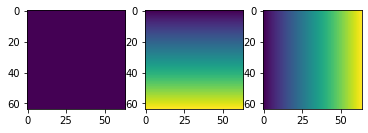

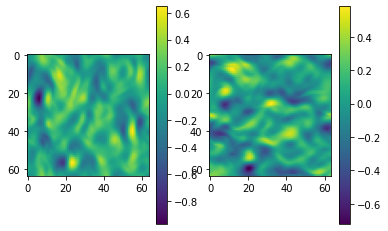

torch.Size([64, 64])


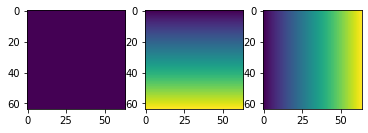

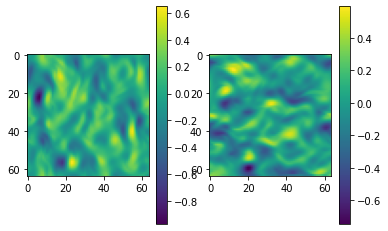

torch.Size([64, 64])


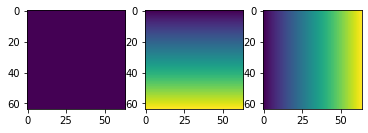

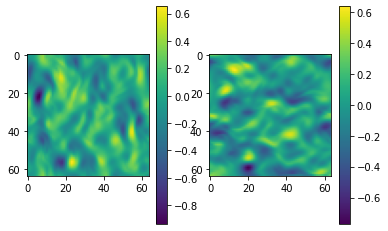

torch.Size([64, 64])


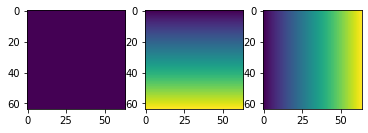

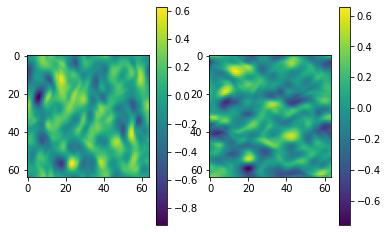

torch.Size([64, 64])


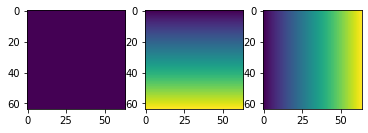

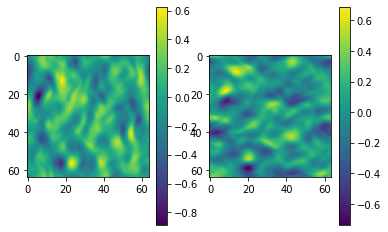

torch.Size([64, 64])


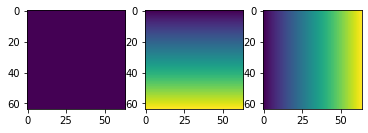

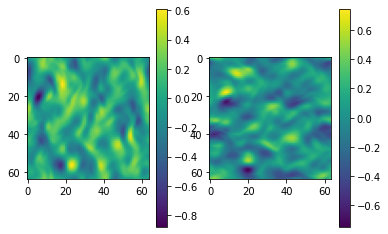

torch.Size([64, 64])


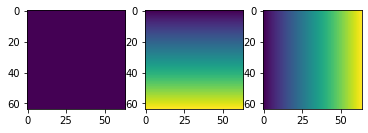

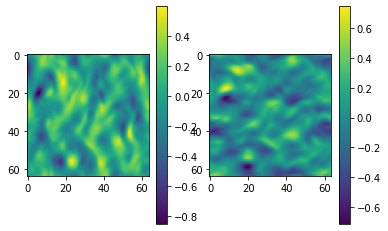

torch.Size([64, 64])


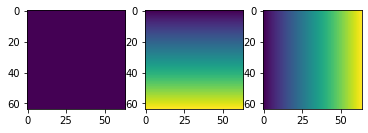

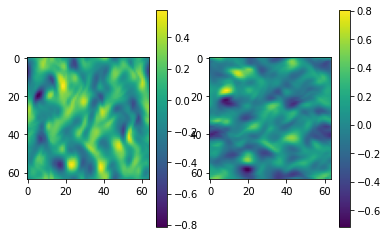

torch.Size([64, 64])


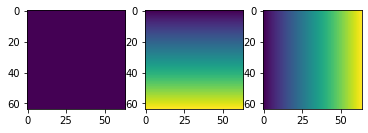

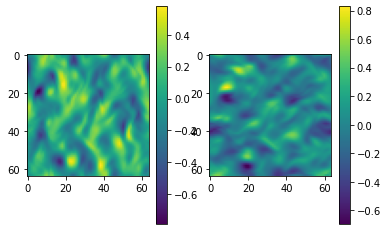

torch.Size([64, 64])


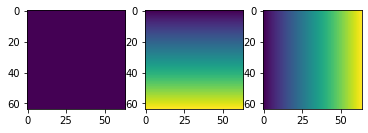

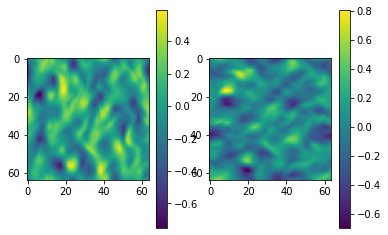

torch.Size([64, 64])


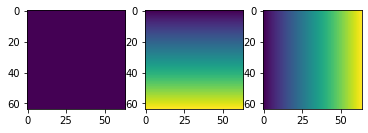

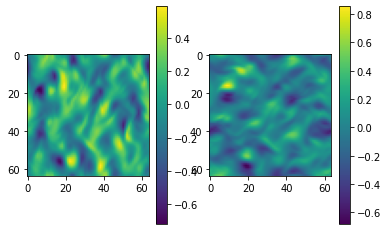

torch.Size([64, 64])


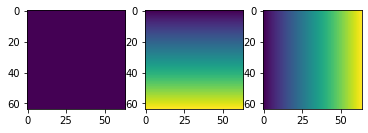

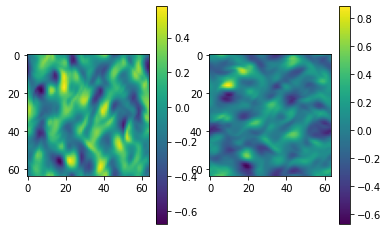

torch.Size([64, 64])


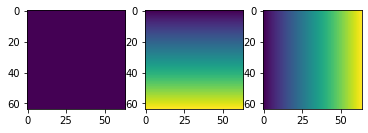

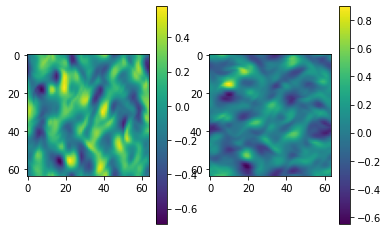

torch.Size([64, 64])


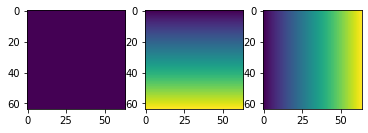

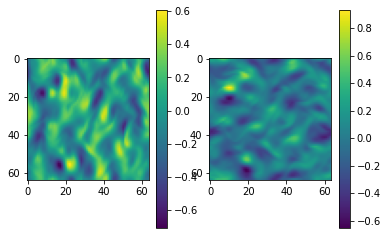

torch.Size([64, 64])


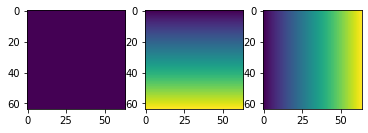

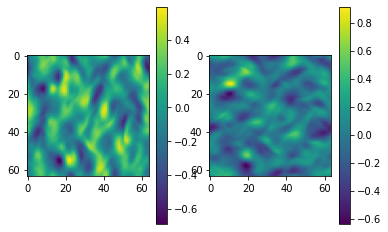

In [24]:
dataset = dm.train_dataset

X, y = dataset[:]
img_shape = dataset.img_shape
vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

T = dataset.times
L = img_shape[0]
N = X.shape[0]
D = X.shape[-1]

print('Low Resolution data:')
print('-- D dimensions:', D)
print('-- T times:', T)
print('-- N samples:', N)
print('-- R resolution img:', L)
print('-- img-like input shape:', vshape)
print('-- vct-like input shape:', tuple(X.shape))
print('-- img-like output shape:', fshape)
print('-- vct-like output shape:', tuple(y.shape))

print(y.max(), y.min())

# if T > 1:
for i in range(T):
    plt.title(i)
    plt.subplot(131)
    plt.imshow(X.reshape(*vshape)[i,:,:,0])
    print(X.reshape(*vshape)[i,:,:,0].shape)
    plt.subplot(132)
    plt.imshow(X.reshape(*vshape)[i,:,:,1])
    plt.subplot(133)
    plt.imshow(X.reshape(*vshape)[i,:,:,2])
    plt.show()
    plt.subplot(121)
    plt.imshow(y.reshape(*fshape)[i,:,:,0])
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(y.reshape(*fshape)[i,:,:,1])
    plt.colorbar()
    plt.show()
# else:
#     plt.subplot(131)
#     plt.imshow(X.reshape(*vshape)[:,:,0])
#     plt.subplot(132)
#     plt.imshow(X.reshape(*vshape)[:,:,1])
#     plt.show()
#     plt.subplot(121)
#     plt.imshow(y.reshape(*fshape)[:,:,0])
#     plt.colorbar()
#     plt.subplot(122)
#     plt.imshow(y.reshape(*fshape)[:,:,1])
#     plt.colorbar()
#     plt.show()
#     print(y.min(), y.max())

In [25]:
from turboflow.models.phyrff import plDivFreeRFFNet

# choose the hyperparams
hparams = {
    'name':'RFFNet',
    'do_time' : True,
    'mlp_layers_num': 3,
    'mlp_layers_dim': 256, 
    'mlp_last_actfn': 'tanh',
    'rff_num_space': 128, 
    'rff_scale_space': 10,
    'rff_num_time': 128, 
    'rff_scale_time': 10,
    'do_divfree': False,
    'lam_sdiv': 0,     # spatial grad(u,v) = torch.autograd(u,v)
    'lam_sfn':  0,     # offgrid L2 reg. on Sfun
    'lam_spec': 0,     # L2 diff on the spectrum
    'lam_grads':0,     # offrgid L2 reg. on grad and autograd
    'lam_curl' :0,     # smooth grad of vorticity
    'lam_pde' : 1e-3,
    'lam_weight': 0,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

model = plDivFreeRFFNet(**vars(Namespace(**hparams)))

In [26]:
early_stop_callback = EarlyStopping(monitor='val/loss/tot')
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss/tot",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-{epoch:02d}-{val_loss:.2f}" % (hparams['name']),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1,
                  max_epochs=3000, 
                  log_every_n_steps=20,
                  check_val_every_n_epoch=20, 
                  callbacks=[early_stop_callback,
                             checkpoint_callback])


/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, dm)

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | rff     | Fourier         | 384   
1 | mlp     | MLP             | 197 K 
2 | sp_grad | SpatialGradient | 0     
3 | sp_lapl | Laplacian       | 0     
--------------------------------------------
197 K     Trainable params
384       Non-trainable params
198 K     Total params
0.793     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validating: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
dataset = dm.val_dataset

X, y = dataset[:]
img_shape = dataset.img_shape
vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

print(X.shape)
print(y.shape)

y_hat, P_hat = model(X)
X = X.reshape(*vshape).detach().cpu().numpy()
y_hat = y_hat.reshape(*fshape).detach().cpu().numpy()
y = y.reshape(*fshape).detach().cpu().numpy()

print(P_hat)
print(y.shape)
print(y_hat.shape)

print(y_hat.reshape(*fshape)[0,:,:,0] - y_hat.reshape(*fshape)[1,:,:,0])

torch.Size([16384, 3])
torch.Size([16384, 2])
None
(4, 64, 64, 2)
(4, 64, 64, 2)
[[ 0.00892986 -0.02505527 -0.02110244 ... -0.01743606  0.00881916
   0.00626174]
 [ 0.00666267 -0.01606813 -0.01048609 ...  0.00517447 -0.00403695
   0.01575808]
 [ 0.01860581 -0.00187125  0.00531966 ...  0.00046699 -0.00880069
   0.01534304]
 ...
 [ 0.00140939 -0.01388177 -0.01899709 ...  0.03096992  0.0324739
   0.0149254 ]
 [-0.0020912  -0.01923345 -0.0167999  ...  0.01494496  0.01067699
   0.00491621]
 [ 0.00205842 -0.01425925 -0.02334799 ...  0.00339331  0.00199312
  -0.00287618]]


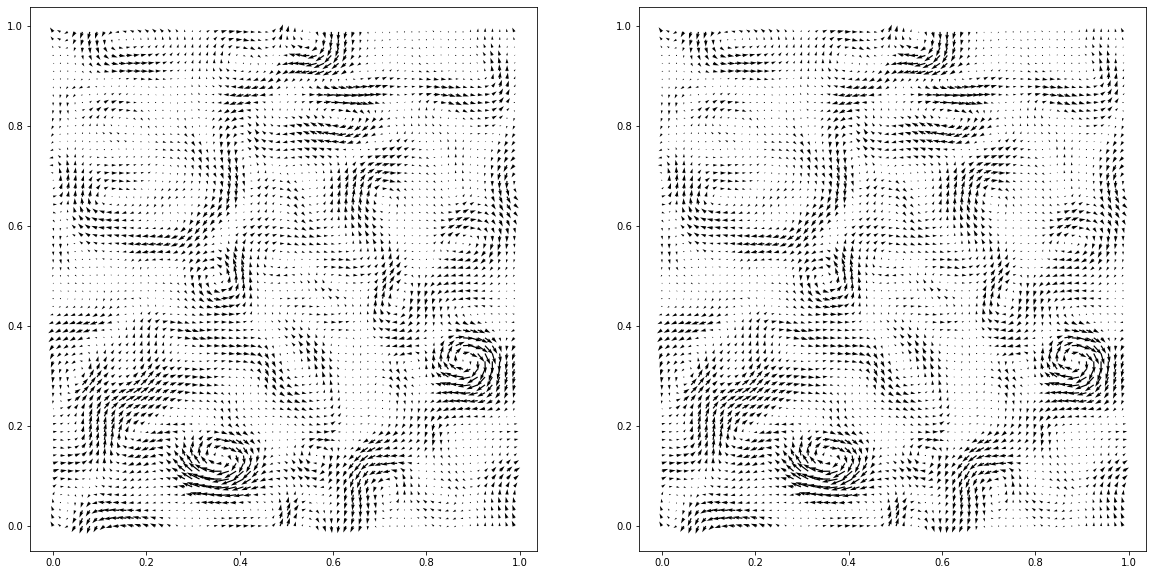

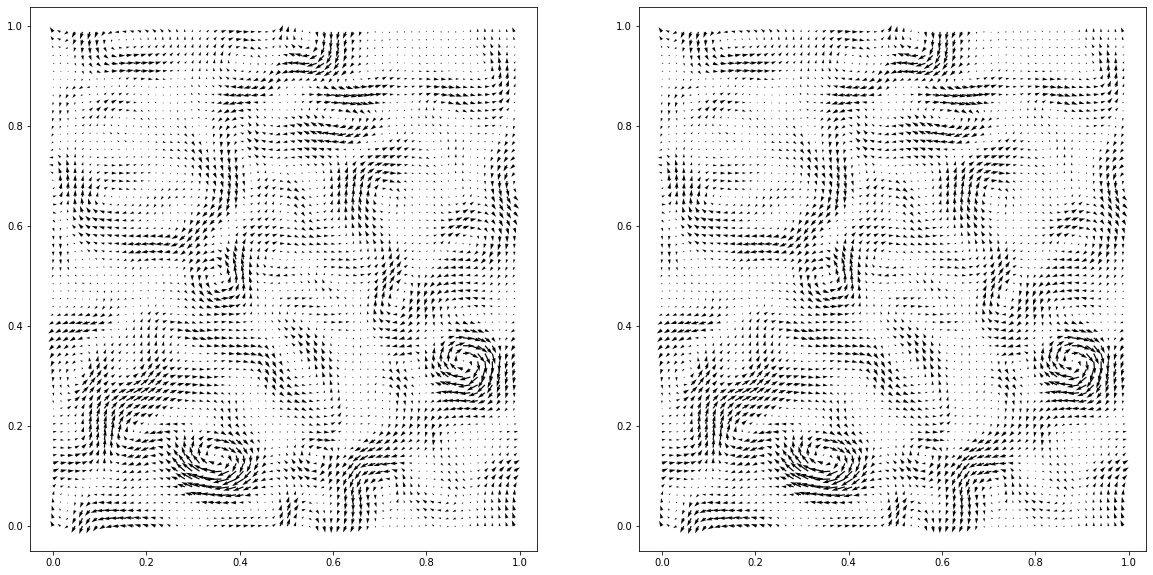

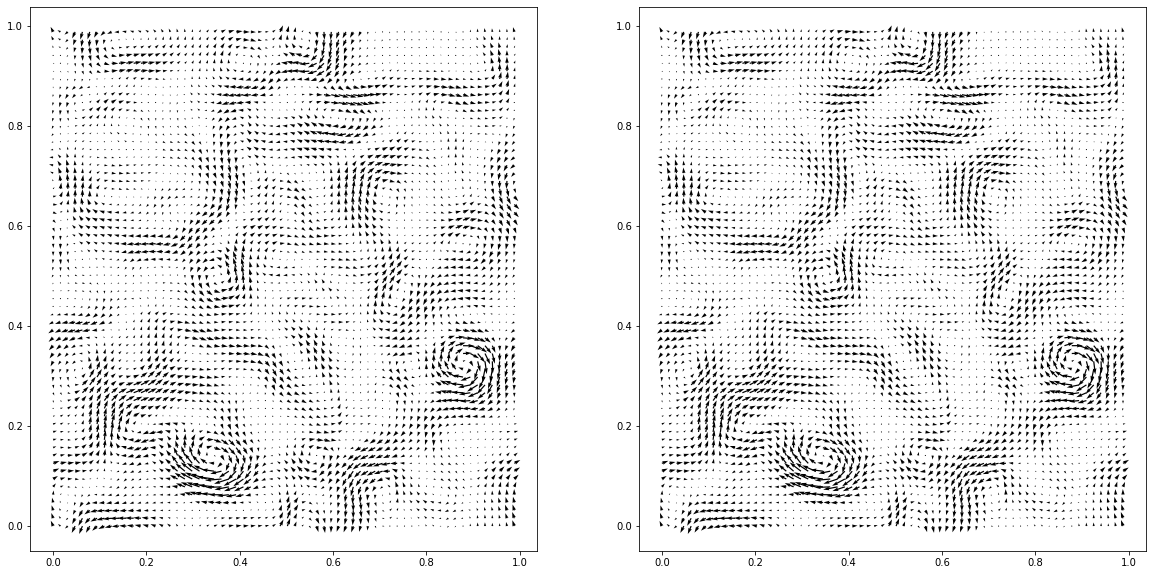

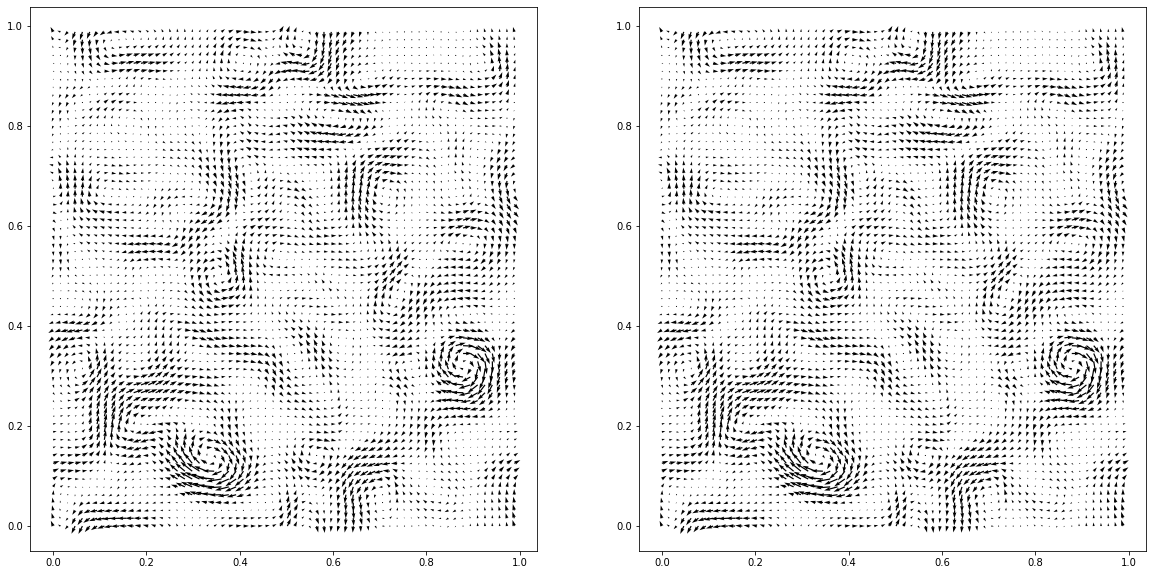

IndexError: index 4 is out of bounds for axis 0 with size 4

In [17]:
ds = 1
for i in range(0,20):
    a = X.reshape(*vshape)[i,:,:,1]
    b = X.reshape(*vshape)[i,:,:,2]
    u = y.reshape(*fshape)[i,:,:,0]
    v = y.reshape(*fshape)[i,:,:,1]
    u_hat = y_hat.reshape(*fshape)[i,:,:,0]
    v_hat = y_hat.reshape(*fshape)[i,:,:,1]
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.quiver(a[::ds,::ds], b[::ds,::ds], u[::ds,::ds], v[::ds,::ds])
    plt.subplot(122)
    plt.quiver(a[::ds,::ds], b[::ds,::ds], u_hat[::ds,::ds], v_hat[::ds,::ds])
    plt.show()
#     plt.subplot(131)
#     plt.imshow(X.reshape(*vshape)[i,:,:,0])
#     plt.subplot(132)
#     plt.imshow(X.reshape(*vshape)[i,:,:,1])
#     plt.subplot(133)
#     plt.imshow(X.reshape(*vshape)[i,:,:,2])
#     plt.show()
#     plt.subplot(121)
#     plt.imshow(y.reshape(*fshape)[i,:,:,0])
#     plt.subplot(122)
#     plt.imshow(y.reshape(*fshape)[i,:,:,1])
#     plt.show()
#     plt.subplot(121)
#     plt.imshow(y_hat.reshape(*fshape)[i,:,:,0])
#     plt.subplot(122)
#     plt.imshow(y_hat.reshape(*fshape)[i,:,:,1])
#     plt.show()

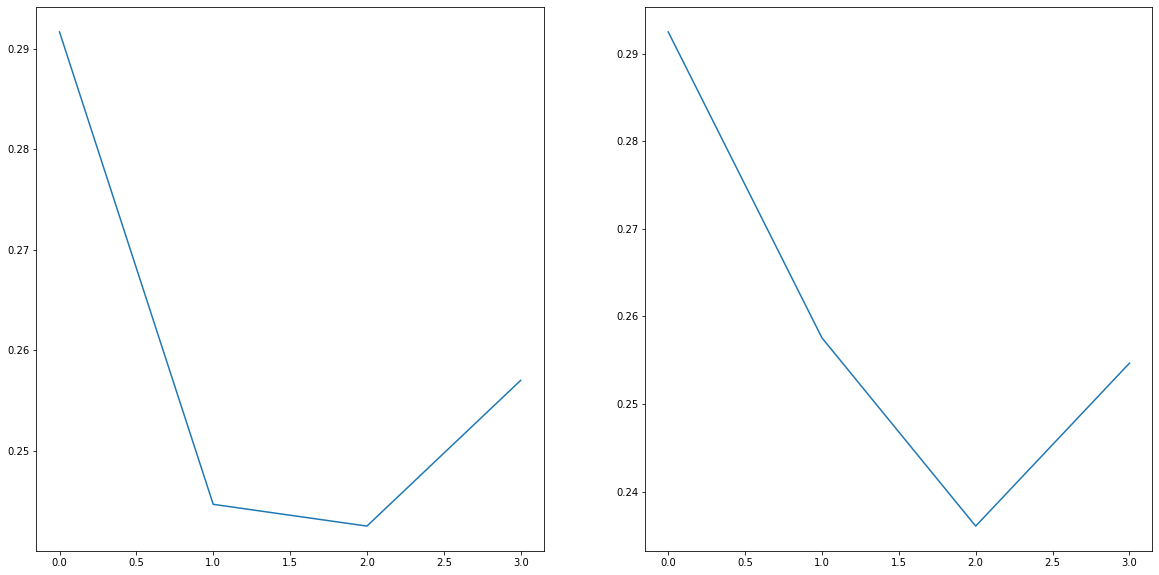

In [19]:
a = X.reshape(*vshape)[:,:,:,1]
b = X.reshape(*vshape)[:,:,:,2]
u = y.reshape(*fshape)[:,:,:,0]
v = y.reshape(*fshape)[:,:,:,1]
u_hat = y_hat.reshape(*fshape)[:,:,:,0]
v_hat = y_hat.reshape(*fshape)[:,:,:,1]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(u[:,18,20])
plt.subplot(122)
plt.plot(u_hat[:,18,20])
plt.show()

In [20]:
dataset = dm.test_dataset

X, y = dataset[:]
img_shape = dataset.img_shape
vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

print(X.shape)
print(y.shape)

y_hat, P_hat = model(X)
X = X.reshape(*vshape).detach().cpu().numpy()
y_hat = y_hat.reshape(*fshape).detach().cpu().numpy()
y = y.reshape(*fshape).detach().cpu().numpy()

print(P_hat)
print(y.shape)
print(y_hat.shape)

print(y_hat.reshape(*fshape)[2,:,:,0] - y_hat.reshape(*fshape)[3,:,:,0])

torch.Size([16384, 3])
torch.Size([16384, 2])
None
(4, 64, 64, 2)
(4, 64, 64, 2)
[[-0.00334226 -0.02053595 -0.01724688 ...  0.0198968   0.00396936
   0.01082341]
 [ 0.00161067  0.00124159 -0.01313929 ...  0.00195567  0.00648239
   0.00754412]
 [-0.00082706 -0.00034178  0.01004878 ... -0.00058955  0.00404198
   0.00726575]
 ...
 [-0.00057955 -0.01230058 -0.02037119 ...  0.03593342  0.02741896
   0.01847733]
 [-0.00091897 -0.00951624 -0.02402647 ...  0.03157272  0.02075841
   0.00665783]
 [-0.01096467 -0.01690432 -0.00761391 ...  0.01562452  0.00153071
  -0.00357307]]


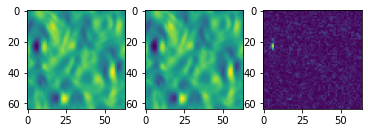

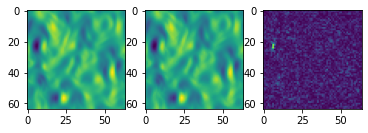

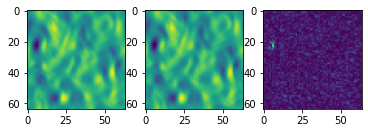

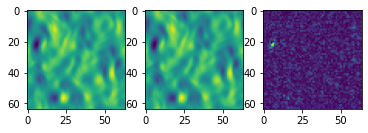

In [21]:
for i in range(4):
    plt.subplot(131)
    plt.imshow(y.reshape(*fshape)[i,:,:,0])
    plt.subplot(132)
    plt.imshow(y_hat.reshape(*fshape)[i,:,:,0])
    plt.subplot(133)
    plt.imshow(np.abs(y-y_hat).reshape(*fshape)[i,:,:,0])
    plt.show()

In [ ]:
X_lr, y_lr = dm.val_dataset[:]
img_shape_lr = dm.val_dataset.img_shape[:2]
shape_lr = dm.val_dataset.img_shape

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape

print(X_lr.shape, y_lr.shape)
print(X_hr.shape, y_hr.shape)

y_hat_lr, P_hat_lr = model(X_lr)
y_hat_hr, P_hat_hr = model(X_hr)

print(y_hat_lr.shape)
print(y_hat_hr.shape)

err_lr = torch.abs(y_hat_lr - y_lr)**2
err_hr = torch.abs(y_hat_hr - y_hr)**2

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Pred LR')
plt.imshow(y_hat_lr[:,0].reshape(*img_shape_lr).detach())
plt.subplot(132)
plt.title('GT LR')
plt.imshow(y_lr[:,0].reshape(*img_shape_lr).detach())
plt.subplot(133)
plt.title('Error LR')
plt.imshow(err_lr[:,0].reshape(*img_shape_lr).detach())
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Pred HR')
plt.imshow(y_hat_hr[:,0].reshape(*img_shape_hr).detach())
plt.subplot(132)
plt.title('GT HR')
plt.imshow(y_hr[:,0].reshape(*img_shape_hr).detach())
plt.subplot(133)
plt.title('Error HR')
plt.imshow(err_hr[:,0].reshape(*img_shape_hr)[5:-5,5:-5].detach())
plt.show()

if P_hat_hr is not None:
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Pred LR')
    plt.imshow(P_hat_lr[:,0].reshape(*img_shape_lr).detach())
    plt.subplot(122)
    plt.title('GT LR')
    plt.imshow(P_hat_hr[:,0].reshape(*img_shape_hr).detach())
    plt.show()

In [ ]:
from kornia.filters import SpatialGradient
sp_grad = SpatialGradient(mode='diff',normalized=True)

In [ ]:
res = 64
x = torch.linspace(0, 1, res, device=model.device)
xx, xy = torch.meshgrid([x, x])
x = torch.cat([xx.flatten()[:,None], xy.flatten()[:,None]], dim=-1)
x.requires_grad_(True)
y_hat_off, _ = model.forward(x)

plt.imshow(y_hat_off[:,0].reshape(res,res).detach())
plt.colorbar()
plt.show()

In [ ]:
# compute the spatial gradient of the groundtruth
y_img_hat = y_lr.view(1,L,L,2).permute(0,3,1,2)
grads = sp_grad(y_img_hat)
img_u_x = grads[0,0,1,...] # we take this inverted as it was we are doing ij indexing
img_u_y = grads[0,0,0,...] # we take this inverted as it was we are doing ij indexing
img_v_x = grads[0,1,1,...] # we take this inverted as it was we are doing ij indexing
img_v_y = grads[0,1,0,...] # we take this inverted as it was we are doing ij indexing

plt.figure(figsize=(20,5))
plt.suptitle('Spatial gradient LR')
plt.subplot(141)
plt.imshow(img_u_x.detach())
plt.subplot(142)
plt.imshow(img_u_y.detach())
plt.subplot(143)
plt.imshow(img_v_x.detach())
plt.subplot(144)
plt.imshow(img_v_y.detach())
plt.colorbar()
plt.show()

# compute the spatial gradient of the prediction
y_img_hat = y_hat_off.view(1,res,res,2).permute(0,3,1,2)
grads = sp_grad(y_img_hat)
img_u_x = grads[0,0,1,...] # we take this inverted as it was we are doing ij indexing
img_u_y = grads[0,0,0,...] # we take this inverted as it was we are doing ij indexing
img_v_x = grads[0,1,1,...] # we take this inverted as it was we are doing ij indexing
img_v_y = grads[0,1,0,...] # we take this inverted as it was we are doing ij indexing

plt.figure(figsize=(20,5))
plt.suptitle('Spatial gradient HR')
plt.subplot(141)
plt.imshow(img_u_x.detach())
plt.subplot(142)
plt.imshow(img_u_y.detach())
plt.subplot(143)
plt.imshow(img_v_x.detach())
plt.subplot(144)
plt.imshow(img_v_y.detach())
plt.colorbar()
plt.show()

# compute the gradient of the prediction with autograd
u, v = torch.split(y_hat_off,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]

du_x = du_xy[:,0].reshape(res,res) / res
du_y = du_xy[:,1].reshape(res,res) / res
dv_x = dv_xy[:,0].reshape(res,res) / res
dv_y = dv_xy[:,1].reshape(res,res) / res

plt.figure(figsize=(20,5))
plt.suptitle('Autograd gradient HR')
plt.subplot(141)
plt.imshow(du_x.detach())
plt.subplot(142)
plt.imshow(du_y.detach())
plt.subplot(143)
plt.imshow(dv_x.detach())
plt.subplot(144)
plt.imshow(dv_y.detach())
plt.colorbar()
plt.show()

gdiff_u_x = torch.abs(img_u_x - du_x)**1
gdiff_u_y = torch.abs(img_u_y - du_y)**1
gdiff_v_x = torch.abs(img_v_x - dv_x)**1
gdiff_v_y = torch.abs(img_v_y - dv_y)**1

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(gdiff_u_x.detach().cpu())
plt.subplot(142)
plt.imshow(gdiff_u_y.detach().cpu())
plt.subplot(143)
plt.imshow(gdiff_v_x.detach().cpu())
plt.subplot(144)
plt.imshow(gdiff_v_y.detach().cpu())
plt.colorbar()
plt.show()

In [ ]:
w = dv_x - du_y
plt.imshow(w.detach().cpu())

In [ ]:
x = X_lr[:,0].detach()
y = X_lr[:,1].detach()
u = y_hat_lr[:,0].detach()
v = y_hat_lr[:,1].detach()

s = 1
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_lr)[::s,::s], 
           y.reshape(*img_shape_lr)[::s,::s],
           u.reshape(*img_shape_lr)[::s,::s],
           v.reshape(*img_shape_lr)[::s,::s], scale=10)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_lr)[::s,::s], 
                   y.reshape(*img_shape_lr)[::s,::s],
           y_lr[:,0].reshape(*img_shape_lr)[::s,::s],
           y_lr[:,1].reshape(*img_shape_lr)[::s,::s], scale=10)

In [ ]:
x = X_lr[:,0].detach()
y = X_lr[:,1].detach()
u_diff = y_hat_lr[:,0].detach() - y_lr[:,0].detach()
v_diff = y_hat_lr[:,1].detach() - y_lr[:,1].detach()

s = 1
plt.figure(figsize=(10,10))
plt.quiver(x.reshape(*img_shape_lr)[::s,::s], 
           y.reshape(*img_shape_lr)[::s,::s],
           u_diff.reshape(*img_shape_lr)[::s,::s],
           v_diff.reshape(*img_shape_lr)[::s,::s], scale=10)

In [ ]:
s = 1
plt.figure(figsize=(10,10))
plt.streamplot(        
           x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,0].reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,1].reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)
plt.streamplot(x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)

In [ ]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

s = 4
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_hr)[::s,::s], 
           y.reshape(*img_shape_hr)[::s,::s],
           u.reshape(*img_shape_hr)[::s,::s],
           v.reshape(*img_shape_hr)[::s,::s], scale=10)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_hr)[::s,::s], 
                   y.reshape(*img_shape_hr)[::s,::s],
           y_hr[:,0].reshape(*img_shape_hr)[::s,::s],
           y_hr[:,1].reshape(*img_shape_hr)[::s,::s], scale=10)


x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u_diff = y_hat_hr[:,0].detach() - y_hr[:,0].detach()
v_diff = y_hat_hr[:,1].detach() - y_hr[:,1].detach()

plt.figure(figsize=(10,10))
plt.quiver(x.reshape(*img_shape_hr)[::s,::s], 
           y.reshape(*img_shape_hr)[::s,::s],
           u_diff.reshape(*img_shape_hr)[::s,::s],
           v_diff.reshape(*img_shape_hr)[::s,::s], scale=10)
plt.show()

In [ ]:
s = 1
plt.figure(figsize=(20,20))
plt.streamplot(
           x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_hr)[::s,::s].T.numpy(),density=3)
plt.streamplot(        
           x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,0].reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,1].reshape(*img_shape_hr)[::s,::s].T.numpy(),density=3)

In [ ]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

d = 1
l = 64
s = 10
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_hr)[:l:d,:l:d], 
           y.reshape(*img_shape_hr)[:l:d,:l:d],
           u.reshape(*img_shape_hr)[:l:d,:l:d],
           v.reshape(*img_shape_hr)[:l:d,:l:d], scale=s)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_hr)[:l:d,:l:d], 
                   y.reshape(*img_shape_hr)[:l:d,:l:d],
           y_hr[:,0].reshape(*img_shape_hr)[:l:d,:l:d],
           y_hr[:,1].reshape(*img_shape_hr)[:l:d,:l:d], scale=s)

In [ ]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

d = 1
l = 64
s = 10
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(u.reshape(*img_shape_hr)[:l:d,:l:d])
plt.subplot(122)
plt.imshow(y_hr[:,0].reshape(*img_shape_hr)[:l:d,:l:d])
plt.show()
plt.imshow((y_hr[:,0]-u).reshape(*img_shape_hr)[:l:d,:l:d])
plt.colorbar()

In [ ]:
print(compute_all_metrics(y_hat_lr, y_lr))
print(compute_all_metrics(y_hat_hr, y_hr))

In [ ]:
# compute spectrum
spec_ns = phy.energy_spectrum(torch.randn(*shape_hr).permute(2,0,1))[0]
spec_lr = phy.energy_spectrum(y_lr.view(*shape_lr).permute(2,0,1))[0]
spec_hr = phy.energy_spectrum(y_hr.view(*shape_hr).permute(2,0,1))[0]

spec_lr_pred = phy.energy_spectrum(y_hat_lr.view(*shape_lr).permute(2,0,1))[0]
spec_hr_pred = phy.energy_spectrum(y_hat_hr.view(*shape_hr).permute(2,0,1))[0]

# plt.loglog(spec_ns)
plt.loglog(spec_lr)
plt.loglog(spec_hr)
plt.loglog(spec_lr_pred.detach())
plt.loglog(spec_hr_pred.detach())


In [ ]:
err = (spec_hr - spec_hr_pred)
plt.plot(err.detach())
plt.plot(spec_hr.detach())
plt.plot(spec_hr_pred.detach())
print(err.sum())
print()
# spec error
# spec_log_error_lr = torch.norm(torch.log(spec_lr_pred+1e-20) - torch.log(spec_lr+1e-20))**2
# spec_log_error_hr = torch.norm(torch.log(spec_hr_pred+1e-20) - torch.log(spec_hr+1e-20))**2

# print(spec_error_lr.item())
# print(spec_error_hr.item())

In [ ]:
# angular error
def ang_error(x, x_ref, avg=True):
    assert x.shape == x_ref.shape
    assert x.shape[1] == 2
    N = x.shape[0]
    
    w1 = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)
    w2 = torch.cat([x_ref, torch.ones(x_ref.shape[0], 1)], dim=1)
    
    err = torch.sum(w1 * w2, dim=1) / (torch.norm(w1, dim=1) * torch.norm(w2, dim=1))
    assert err.sum() < N
    err = torch.rad2deg(torch.acos(err))
    if avg:
        return err.mean()
    return err
    

ang_err_lr = ang_error(y_lr, y_hat_lr, avg=True)
ang_err_hr = ang_error(y_hr, y_hat_hr, avg=True)

print(torch.max(ang_error(y_lr, y_hat_lr, avg=False)))
print(torch.max(ang_error(y_hr, y_hat_hr, avg=False)))


In [ ]:
model = plDivFreeRFFNet.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(model, dm)

In [ ]:
spec_lr_err = phy.energy_spectrum(((y_hat_lr-y_lr)**2).view(*img_shape_lr).permute(2,0,1))[0]
spec_hr_err = phy.energy_spectrum(((y_hat_hr-y_hr)**2).view(*img_shape_hr).permute(2,0,1))[0]

plt.loglog(spec_lr_err.detach())
plt.loglog(spec_hr_err.detach())

In [ ]:
y_hat, Py_hat = model(X_lr)
u, v = torch.split(y_hat,1,-1)
du_xy = torch.autograd.grad(u, X_lr, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, X_lr, torch.ones_like(v), create_graph=True)[0]
# div_autograd = du_xy[...,0] + dv_xy[...,1]
div_autograd = dv_xy[...,1]
div_autograd = div_autograd.view(*img_shape_lr[:2])

plt.imshow(div_autograd.detach())
plt.colorbar()
plt.show()

du_x = tch._my_field_grad(y_hat.view(*img_shape_lr)[:,:,0], 1)
du_y = tch._my_field_grad(y_hat.view(*img_shape_lr)[:,:,1], 0)
div_numerical = du_y
    
plt.imshow(div_numerical.detach())
plt.colorbar()
plt.show()

plt.imshow((div_numerical - div_autograd).detach())
plt.colorbar()
plt.show()


In [ ]:
y_hat, Py_hat = model(X_hr)
u, v = torch.split(y_hat,1,-1)
du_xy = torch.autograd.grad(u, X_hr, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, X_hr, torch.ones_like(v), create_graph=True)[0]
# div_autograd = du_xy[...,0] + dv_xy[...,1]
div_autograd = dv_xy[...,1]
div_autograd = div_autograd.view(*img_shape_hr[:2])

plt.imshow(div_autograd[2:-2,2:-2].detach())
plt.colorbar()
plt.show()

du_x = tch._my_field_grad(y_hat.view(*img_shape_hr)[:,:,0], 1)
du_y = tch._my_field_grad(y_hat.view(*img_shape_hr)[:,:,1], 0)
div_numerical = du_y
    
plt.imshow(div_numerical[2:-2,2:-2].detach())
plt.colorbar()
plt.show()

plt.imshow((div_numerical[2:-2,2:-2] - div_autograd[2:-2,2:-2]).detach())
plt.colorbar()
plt.show()
